In [106]:
import pandas as pd
import re
import numpy as np
from textblob import TextBlob
from datetime import datetime
import os
from numpy import nan
import seaborn as sns
from sklearn import feature_selection
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics

sns.set_style("whitegrid")

In [107]:
dreamMarket = pd.read_csv('dreamMarket.csv', encoding='latin1')
vendors = pd.read_csv('vendor2018_all.csv', encoding='latin1')
offers = pd.read_csv('dreamMarketOffersMapping.csv', encoding='latin1')
succTrans = pd.read_csv('succTrans.csv', encoding='latin1')

In [108]:
dreamMarket.columns.values

array(['date', 'offerId', 'vendorName', 'title', 'price', 'prodDesc',
       'terms', 'shipTo', 'shipFrom', 'rates', 'rating', 'vendorStatus',
       'escrow'], dtype=object)

In [109]:
# get fx btc to usd
dreamMarket['btcToUsd'] = dreamMarket.apply(lambda row: row.rates.split('_*_')[0].replace('$', '').strip(), axis=1)

In [110]:
dreamMarket['btcToUsd'] = pd.to_numeric(dreamMarket['btcToUsd'])

In [111]:
dreamMarket['btcToUsd'].head()

0    244.9
1    244.9
2    244.9
3    244.9
4    244.9
Name: btcToUsd, dtype: float64

In [112]:
# price of pruduct that was orginally stated in usd or btc, thats why the btc/usd exchange is needed
def givePrice(p, btc):
    if len(p.split(' ')) == 2:
        return float(p.split(' ')[1][1:])
    else:
        return float(p[1:]) * btc
dreamMarket['priceUsd'] = dreamMarket.apply(lambda row: givePrice(row.price, row.btcToUsd), axis = 1)
dreamMarket = dreamMarket.drop('price', axis = 1)

In [113]:
# get countries that vendor ships to and shipping prices
countries = ['shipToUSA', 'shipToAustralia', 'shipToEU', 'shipToCanada', 'shipWorldwide']
prices = ['shipToUSAPrice', 'shipToAustraliaPrice', 'shipToEUPrice', 'shipToCanadaPrice', 'shipWorldwidePrice']
coutryPatt = {'shipToUSA': 'USA|US|States', 'shipToAustralia': 'Australia|Au|Aus', 'shipToEU': 'Europe|EU|Eur|Germany', 'shipWorldwide': 'Worldwide|world|International|Everywhere', 'shipToCanada': 'Canada|CA'}

In [114]:
# return True if found pattern in string
def findPat(country, string):
    string = ' ' + string + ' '
    try:
        re.search(r'\b' + country + r'\b', string, re.IGNORECASE).group(0)
        flag = True
    except:
        flag = False
    return flag

In [115]:
# get countries bassed on dictionary with patterns
def getCountries(val, price, c, p):
    c = list(c)
    p = list(p)
    for i, country in enumerate(countries):
        if findPat(coutryPatt[country], val):
            c[i] = 1
            p[i] = price
    return [list(c), list(p)]
# finds exceptions inside countires list that vendor ships to (for example: 'All countries without US')
def getCountriesExcept(val, c, p):
    c = list(c)
    p = list(p)
    for i, country in enumerate(countries):
        if findPat(coutryPatt[country], val):
            c[i] = 0
            p[i] = None
    return [list(c), list(p)]

In [116]:
# make three columns: shipToUSA, shipToAustralia, shipToEU
data = []
for ind, obs in enumerate(dreamMarket['shipTo'][~dreamMarket['shipTo'].isnull()]):
    # splitting multiple conditions for range of countries
    x = obs.split('_%_')
    # 0 + 2 * i is price, 1 + 2 * i is country
    countr = [None, None, None, None, None]
    pric = [None, None, None, None, None]
    for i, val in enumerate(x):
        flag = False
        # if price
        if i%2 == 0:
            try:
                shipPrice = re.search('(?<=\$|).*?(?=\))', val).group(0)
            except:
                shipPrice = val.replace('?', '').strip()
                # when previous pattern was not enought
                if '(' in shipPrice:
                    shipPrice = re.search('(?<=\().*?(?=\))', shipPrice).group(0)
                else:
                    shipPrice = float(shipPrice) * dreamMarket['btcToUsd'][ind]
        else:
            if len(val.split('*_*')) > 1:
                flag = True
                val = val.split('*_*')[0].strip()
            countr, pric = getCountries(val, shipPrice, countr, pric)
            # if in string was Except word, we have to take in into account
            if findPat('Except', val):
                # give WorldWide value 1 in that case
                countr[4] = 1
                pric[4] = shipPrice
                val = val.upper().split('EXCEPT')[1] # only part before 'except'
                countr, pric = getCountriesExcept(val, countr, pric)
            if flag == True:
                break
    if countr.count(None) == 5:
        countr[4] = 1 # based on obs with all none values, it can be assumed that those vendors ship worldwide
        pric[4] = shipPrice # however, shipPrice is not very informative in that case
    data.append(countr + pric)

In [117]:
shipping = pd.DataFrame(data, columns = countries + prices)

In [118]:
dreamMarketCut = dreamMarket[~dreamMarket['shipTo'].isnull()]

In [119]:
dreamMarketWithShipping = pd.concat([dreamMarketCut.reset_index(drop = True), shipping], axis = 1)

In [120]:
dreamMarketWithShipping

,date,offerId,vendorName,title,prodDesc,terms,shipTo,shipFrom,rates,rating,...,shipToUSA,shipToAustralia,shipToEU,shipToCanada,shipWorldwide,shipToUSAPrice,shipToAustraliaPrice,shipToEUPrice,shipToCanadaPrice,shipWorldwidePrice
0,2015-03-26,102268.503444,attentiondivided,Blue Dream - 5 Grams,"Blue Dream, top shelf California bud - 5 Grams...",PACKAGING :\r\n\r\n1:We use a very stealth pac...,?0.013\t\t\t\t\t _%_ US 4 to 13 Days *_*,United States,$ 244.9_*_ 230.6_*_? 167.3_*_? 1561.2,5.0,...,1.0,NaN,NaN,NaN,NaN,3.1837,None,None,None,None
1,2015-03-26,102758.816244,eurodrugs,5 Gram Heroin VERY GOOD Quality (French seller),I am a french vendor and i sell brown heroine\...,"Hello,\r\n\r\nI am a french vendor and i sell ...","?0.00 (0)\t\t\t\t\t _%_ FRANCE, EUROPE, USA, ...",NaN,$ 244.9_*_ 230.6_*_? 167.3_*_? 1561.2,5.0,...,1.0,NaN,1.0,1.0,NaN,0,None,0,0,None
2,2015-03-26,106867.398488,abruci,Iphone 6 plus (128gb),All information - http://store.apple.com/us/ip...,"FAQ\r\n\r\nOriginal iphones? - yes, there are ...",?0.0816 ($20)\t\t\t\t\t _%_ USA _%_ ?0.0816 ($...,"USA , Russia",$ 244.9_*_ 230.6_*_? 167.3_*_? 1561.2,5.0,...,1.0,NaN,1.0,NaN,1.0,20,None,30,None,50
3,2015-03-26,107186.336588,idealpills,Valium (Roche) 10 MG (400 Pills),Valium (diazepam) is a benzodiazepine (ben-zoe...,::::::(Note)::::::\r\nIdeal Pills is Now Offer...,?0.1224 ($30)\t\t\t\t\t _%_ Express Mail Shipp...,NaN,$ 244.9_*_ 230.6_*_? 167.3_*_? 1561.2,NaN,...,NaN,NaN,NaN,NaN,1.0,None,None,None,None,30
4,2015-03-26,107787.437912,attentiondivided,Lemon Jack Herer - 7 Grams,"Great indica, smooth smoke, nice for wake n' b...",PACKAGING :\r\n\r\n1:We use a very stealth pac...,?0.013\t\t\t\t\t _%_ US 4 to 13 Days *_*,United States,$ 244.9_*_ 230.6_*_? 167.3_*_? 1561.2,5.0,...,1.0,NaN,NaN,NaN,NaN,3.1837,None,None,None,None
5,2015-03-26,110163.398383,PROKITdrugs,0.5 gr TO AFGHANY #3 HEROIN HIGH QUALITY ++++,AFGHANY #3 HEROIN HIGH QUALITY ++++\r\n\r\nThi...,PROKITdrugs TOP SELLER - HIGH QUALITY PRODUCTS...,?0.00 (0)\t\t\t\t\t _%_ FREE SHIPMENT TO EU *_*,NaN,$ 244.9_*_ 230.6_*_? 167.3_*_? 1561.2,4.9,...,NaN,NaN,1.0,NaN,NaN,None,None,0,None,None
6,2015-03-26,114000.305230,attentiondivided,1 Gram Medical Grade - Pick Your Strain,SELECT A STRAIN\r\nQUANTITY: 1 Gram\r\nPRODUCT...,PACKAGING :\r\n\r\n1:We use a very stealth pac...,?0.013\t\t\t\t\t _%_ US 4 to 13 Days *_*,United States,$ 244.9_*_ 230.6_*_? 167.3_*_? 1561.2,5.0,...,1.0,NaN,NaN,NaN,NaN,3.1837,None,None,None,None
7,2015-03-26,115709.771926,bolgar,Faux Billets de 20 Euros - PU 10,Faux Billets de 20 Euros\r\n\r\nVente de faux ...,None given,?0.01084 (2.5)\t\t\t\t\t _%_ Lettre Suivi FRA...,France,$ 244.9_*_ 230.6_*_? 167.3_*_? 1561.2,NaN,...,NaN,NaN,1.0,NaN,NaN,None,None,4.5,None,None
8,2015-03-26,119284.722001,MartyMcfly,250 Xanax Bars 2.6mg,These are pressed generic Xanax bars that we m...,Hello everybody! We are player2_pharma. Althou...,?0.02449 ($6)\t\t\t\t\t _%_ Domestic (US to US...,US,$ 244.9_*_ 230.6_*_? 167.3_*_? 1561.2,NaN,...,1.0,NaN,NaN,NaN,NaN,6,None,None,None,None
9,2015-03-26,122244.157520,benjamindover,5 Grams Afgan Goo HQ {Super Stelth},Afgan Goo 5 Grams\r\n\r\nI will mail you the h...,"Live chat = add me in Wickr, a secure encrypte...",?0.0204 ($5)\t\t\t\t\t _%_ Domestic Shipping 3...,NaN,$ 244.9_*_ 230.6_*_? 167.3_*_? 1561.2,5.0,...,NaN,NaN,NaN,NaN,1.0,None,None,None,None,10


In [121]:
# add observations where there was no countries that vendor ships to
dreamMarketWithoutShipping = dreamMarket.copy()
dreamMarketWithoutShipping = dreamMarketWithoutShipping[dreamMarketWithoutShipping['shipTo'].isnull()]
for name in countries + prices:
    dreamMarketWithoutShipping[name] = None

In [122]:
# merge df with shipping and df where shipping is null
dreamMarket2 = pd.concat([dreamMarketWithShipping, dreamMarketWithoutShipping])

In [123]:
# drop unnecessary cols
dreamMarket2 = dreamMarket2.drop(['shipTo', 'rates'], axis = 1)

In [124]:
# current amount of cols
dreamMarket2.columns.values

array(['date', 'offerId', 'vendorName', 'title', 'prodDesc', 'terms',
       'shipFrom', 'rating', 'vendorStatus', 'escrow', 'btcToUsd',
       'priceUsd', 'shipToUSA', 'shipToAustralia', 'shipToEU',
       'shipToCanada', 'shipWorldwide', 'shipToUSAPrice',
       'shipToAustraliaPrice', 'shipToEUPrice', 'shipToCanadaPrice',
       'shipWorldwidePrice'], dtype=object)

In [125]:
# concatenate dreamMarket2 with dataframe that contains info about categories

In [126]:
offers.head()

,offerId,cat,subCat,title
0,632168.485507,Drugs,Cannabis,Ready2Go CannaPen E-cig Prefilled Oil-Wax W/1 ...
1,448343.552105,Drugs,Psychedelics,14g Panaeolus tropicalis Shrooms 16 Dose FREESHIP
2,100393.801998,Drugs,Cannabis,10g Super Skunk (high-quality)
3,498234.494005,Drugs,Prescriptions,FE DISCOUNT! - x15 Adderall 20 mg.
4,55615.185962,Drugs,Cannabis,AFGHAN OG (ZAMNESIA SEEDS) FEMINIZED x 3 seeds


In [127]:
offers.dtypes

offerId    float64
cat         object
subCat      object
title       object
dtype: object

In [128]:
# clean df
offers['title'] = offers.apply(lambda row: row.title.strip(), axis = 1)
offers['cat'] = offers.apply(lambda row: row['cat'].strip(), axis = 1)

In [129]:
offersDuplicated = offers[offers[['offerId', 'title']].duplicated()]

In [130]:
# some offers ids and titles are duplicated, but there belong to range of categories - dirty data
offers[offers[['offerId', 'title']].duplicated()]
offersDuplicated = offers[offers['offerId'].isin(offersDuplicated['offerId'])].sort_values(by=['offerId'])
offersDuplicated

,offerId,cat,subCat,title
4035,24385.758560,Guides and Tutorials,NaN,Bitcoin Beginners Guide
4634,24385.758560,Digital goods,NaN,Bitcoin Beginners Guide
5798,141894.405970,Drugs,Others,"Kamagra (Viagra, 4 Tablets, Sildenafil 100mg)"
5664,141894.405970,Drugs,Prescriptions,"Kamagra (Viagra, 4 Tablets, Sildenafil 100mg)"
3599,206665.687660,Drugs,Others,100g China White 99% Pure FREE WORLDWIDE SHIPPING
2724,206665.687660,Drugs,Opioids,100g China White 99% Pure FREE WORLDWIDE SHIPPING
3454,250654.690978,Drugs,Others,FREE SAMPLE Viagra/Kamagra
3714,250654.690978,Drugs,Prescriptions,FREE SAMPLE Viagra/Kamagra
4065,363445.259755,Guides and Tutorials,NaN,INFINITIVE_AMAZON_MONEY_METHOD
1723,363445.259755,Digital goods,NaN,INFINITIVE_AMAZON_MONEY_METHOD


Decide to which categories duplicated ids belong to

In [131]:
offersDuplicated.loc[(offersDuplicated['cat'] == 'Drugs') & (offersDuplicated['subCat'] == 'Others'), 'subCat'] = 'Prescriptions'

In [132]:
offersDuplicated.loc[(offersDuplicated['cat'] == 'Digital goods'), 'cat'] = 'Guides and Tutorials'

In [133]:
offersDuplicated.loc[(offersDuplicated['cat'] == 'Medical Supplies'), 'cat'] = 'Drug paraphernalia'

In [134]:
offersDuplicated.iloc[[5], [2]] = 'Opioids'
offersDuplicated.loc[(offersDuplicated['cat'] == 'Medical Supplies'), 'cat'] = 'Drug paraphernalia'

In [135]:
offersDuplicated.loc[(offersDuplicated['offerId'] == 675899.708729) & (offersDuplicated['subCat'] == 'Prescriptions'), 'subCat'] = 'Opioids'

In [136]:
offersDuplicated.loc[(offersDuplicated['offerId'] == 459804.863306) & (offersDuplicated['cat'] == 'Guides and Tutorials'), 'cat'] = 'Custom Orders'

In [137]:
offersDuplicated.loc[(offersDuplicated['offerId'] == 983708.959482), 'subCat'] = 'Benzos'

In [138]:
offersDuplicated.loc[(offersDuplicated['offerId'] == 531583.309636), ['cat', 'subCat']] = ['Guides and Tutorials', 'NaN']

In [139]:
offersDuplicated = offersDuplicated.sort_index()

In [140]:
offers.loc[offers['offerId'].isin(offersDuplicated['offerId']), ['offerId', 'cat', 'subCat', 'title']] = offersDuplicated[['offerId', 'cat', 'subCat', 'title']].values

In [141]:
offers = offers.drop_duplicates()

In [142]:
offers['title'] = offers.apply(lambda row: row.title.strip(), axis = 1)

In [143]:
dreamMarket2['title'] = dreamMarket2.apply(lambda row: row.title.strip(), axis = 1)

In [144]:
dreamMarketMerged = pd.merge(dreamMarket2, offers, on = ['offerId', 'title'], how = 'left')
dreamMarketMerged

,date,offerId,vendorName,title,prodDesc,terms,shipFrom,rating,vendorStatus,escrow,...,shipToEU,shipToCanada,shipWorldwide,shipToUSAPrice,shipToAustraliaPrice,shipToEUPrice,shipToCanadaPrice,shipWorldwidePrice,cat,subCat
0,2015-03-26,102268.503444,attentiondivided,Blue Dream - 5 Grams,"Blue Dream, top shelf California bud - 5 Grams...",PACKAGING :\r\n\r\n1:We use a very stealth pac...,United States,5.0,3,Yes,...,NaN,NaN,NaN,3.1837,None,None,None,None,Drugs,Cannabis
1,2015-03-26,102758.816244,eurodrugs,5 Gram Heroin VERY GOOD Quality (French seller),I am a french vendor and i sell brown heroine\...,"Hello,\r\n\r\nI am a french vendor and i sell ...",NaN,5.0,3,Yes,...,1,1,NaN,0,None,0,0,None,Drugs,Opioids
2,2015-03-26,106867.398488,abruci,Iphone 6 plus (128gb),All information - http://store.apple.com/us/ip...,"FAQ\r\n\r\nOriginal iphones? - yes, there are ...","USA , Russia",5.0,3,No,...,1,NaN,1,20,None,30,None,50,Electronics,NaN
3,2015-03-26,107186.336588,idealpills,Valium (Roche) 10 MG (400 Pills),Valium (diazepam) is a benzodiazepine (ben-zoe...,::::::(Note)::::::\r\nIdeal Pills is Now Offer...,NaN,NaN,0,Yes,...,NaN,NaN,1,None,None,None,None,30,Drugs,Benzos
4,2015-03-26,107787.437912,attentiondivided,Lemon Jack Herer - 7 Grams,"Great indica, smooth smoke, nice for wake n' b...",PACKAGING :\r\n\r\n1:We use a very stealth pac...,United States,5.0,3,Yes,...,NaN,NaN,NaN,3.1837,None,None,None,None,Drugs,Cannabis
5,2015-03-26,110163.398383,PROKITdrugs,0.5 gr TO AFGHANY #3 HEROIN HIGH QUALITY ++++,AFGHANY #3 HEROIN HIGH QUALITY ++++\r\n\r\nThi...,PROKITdrugs TOP SELLER - HIGH QUALITY PRODUCTS...,NaN,4.9,21,No,...,1,NaN,NaN,None,None,0,None,None,Drugs,Opioids
6,2015-03-26,114000.305230,attentiondivided,1 Gram Medical Grade - Pick Your Strain,SELECT A STRAIN\r\nQUANTITY: 1 Gram\r\nPRODUCT...,PACKAGING :\r\n\r\n1:We use a very stealth pac...,United States,5.0,3,Yes,...,NaN,NaN,NaN,3.1837,None,None,None,None,Drugs,Cannabis
7,2015-03-26,115709.771926,bolgar,Faux Billets de 20 Euros - PU 10,Faux Billets de 20 Euros\r\n\r\nVente de faux ...,None given,France,NaN,0,Yes,...,1,NaN,NaN,None,None,4.5,None,None,Counterfeits,NaN
8,2015-03-26,119284.722001,MartyMcfly,250 Xanax Bars 2.6mg,These are pressed generic Xanax bars that we m...,Hello everybody! We are player2_pharma. Althou...,US,NaN,0,Yes,...,NaN,NaN,NaN,6,None,None,None,None,Drugs,Benzos
9,2015-03-26,122244.157520,benjamindover,5 Grams Afgan Goo HQ {Super Stelth},Afgan Goo 5 Grams\r\n\r\nI will mail you the h...,"Live chat = add me in Wickr, a secure encrypte...",NaN,5.0,14,Yes,...,NaN,NaN,1,None,None,None,None,10,Drugs,Cannabis


In [145]:
# range of dates
print(dreamMarketMerged['date'].min())
print(dreamMarketMerged['date'].max())

2015-03-26
2015-07-05


Create features based on sentiment in product desctiptions and terms of use.

Package used: TextBlob with sentiment.polarity method.

It is package based on Natural Language Toolkit and can be used as a tool for simple NLP

In [146]:
prodDescSentiment = []
for description in dreamMarketMerged['prodDesc']:
    txt = TextBlob(description)
    prodDescSentiment.append(txt.sentiment.polarity)
dreamMarketMerged['prodDescSentiment'] = prodDescSentiment

In [147]:
termsSentiment = []
for term in dreamMarketMerged['terms']:
    txt = TextBlob(term)
    termsSentiment.append(txt.sentiment.polarity)
dreamMarketMerged['termsSentiment'] = termsSentiment

In [148]:
# aggregation
def aggregate(df):
    df = df.copy()
    auctionsCount = df.groupby(['vendorName'])['offerId'].count().reset_index('vendorName')
    titlesMeanLen = df.groupby(['vendorName'])['title'].apply(lambda x: np.mean(x.str.len())).reset_index('vendorName')
    prodDescMeanLen = df.groupby(['vendorName'])['prodDesc'].apply(lambda x: np.mean(x.str.len())).reset_index('vendorName')
    termsMeanLen = df.groupby(['vendorName'])['terms'].apply(lambda x: np.mean(x.str.len())).reset_index('vendorName')
    lastRating = pd.merge(df.groupby(['vendorName'])['date'].max().reset_index('vendorName'), \
                          df[['vendorName', 'date', 'rating']], on = ['vendorName', 'date'], \
                          how = 'left').drop_duplicates()[['vendorName', 'rating']]
    lastStatus = pd.merge(df.groupby(['vendorName'])['date'].max().reset_index('vendorName'), \
                          df[['vendorName', 'date', 'vendorStatus']], on = ['vendorName', 'date'], \
                          how = 'left').drop_duplicates()[['vendorName', 'vendorStatus']]
    termsSentimentMean = df.groupby(['vendorName'])['termsSentiment'].apply(lambda x: np.mean(x)).reset_index('vendorName')
    prodDescSentimentMean = df.groupby(['vendorName'])['prodDescSentiment'].apply(lambda x: np.mean(x)).reset_index('vendorName')
    df = auctionsCount.copy()
    df['titlesMeanLen'] = titlesMeanLen['title'].values
    df['prodDescMeanLen'] = prodDescMeanLen['prodDesc'].values
    df['termsMeanLen'] = termsMeanLen['terms'].values
    df['lastRating'] = lastRating['rating'].values
    df['lastStatus'] = lastStatus['vendorStatus'].values
    df['prodDescSentimentMean'] = prodDescSentimentMean['prodDescSentiment'].values
    df['termsSentimentMean'] = termsSentimentMean['termsSentiment'].values
    return df

In [149]:
dreamMarketAggregated = aggregate(dreamMarketMerged).copy()

In [150]:
# consisten within countries
dreamMarketMerged.shipFrom.apply(lambda x: str(x).upper()).unique()

array(['UNITED STATES', 'NAN', 'USA , RUSSIA', 'FRANCE', 'US',
       'NETHERLANDS', 'SPAIN', 'GERMANY', 'USA', 'BELGIUM',
       'UNITED KINGDOM', 'USA TO USA ONLY', 'UK', 'INDIA', 'INTERNET',
       'CANADA', 'US TO US', 'USA TO USA', 'NL', 'CANADA AUSTRALIA', 'E.U',
       'EUROPE', 'WORLD WIDE', 'WORLDWIDE', 'UNITED KINDOM', 'HOLLAND',
       'IRELAND', 'PM', 'TODO EL MUNDO NO ASTRALIA', 'TORLAND',
       'UNITED KINDOOM', 'WEBSITE', 'EU', 'NORTH AMERICA', 'WORLD',
       'SWEDEN', 'ITALY', 'UNITED KINGDOOM', 'COLOMBIA', 'SWITZERLAND',
       'U.K.', 'SWISS ONLY', 'THE NETHERLANDS', 'AUSTRIA',
       'CROATIA TO WORLDWIDE', 'DUTCH', 'DEUTSCHLAND', 'CROATIA', 'GERMAY',
       'HONGKONG', 'UNITED STATES OF AMERICA', 'DENMARK', 'MEXICO',
       'KOREA', 'KONGHONG', 'MOROCCO', 'AUSTRALIA', 'POLAND', 'DANMARK',
       'HOME', 'GLOBAL', 'SOUTH AFRICA', 'UNITED STEATES',
       'OPIATE PERCOCETS', 'UNITED STEATS', 'CHINA', 'SCHWEIZ', 'ASIA',
       'UK AND PHILIPPINES', 'PHILIPPINES', 'EU

In [151]:
countryUniq = list(dreamMarketMerged.shipFrom.apply(lambda x: str(x).upper()).unique())

In [152]:
USA = ['U.S.', 'UNITED STATES', 'CAN', 'UNITED STATES', 'UNITED STATES OF AMERICA', 'UNITED STEATES', 'UNITED STEATS', 'UNIITED STATES', 'US', 'NORTH AMERICA', 'UNITES STATES', 'ARIZONA, USA']
Germany = ['GERMANY', 'GERMAY', 'GERMNAY', 'GERMAN', 'GER', 'GERMANZ', 'DEUTSCHLAND', 'DE', 'GE']
Netherlands = ['NL', 'NETHERLANDS', 'THE NETHERLANDS', 'NETHERLAND', 'HOLLAND', 'THE NETHERLANDS/BELGIUM']
UK = ['WEST COAST', 'UINTED KINGDOM', 'U.K', 'UK', 'UNITED KINGDOM', 'UNITED KINDOM', 'UNITED KINDOOM', 'UNITED KINGDOOM', 'U.K.', 'UK, PHILIPPINES', 'UK AND PHILIPPINES']
EU = ['EU', 'EUROPE UNION', 'EUROPEAN UNION', 'EUROPA', 'EUROPE', 'UK OR EU', 'UK OR MID EUROPE', 'E.U', 'UK OR MID EUROPE', 'BENELUX (EU)', 'UE']
FR = ['FRANCE', 'FR', 'FRENCH']
World = ['CROATIA TO WORLDWIDE', 'WORLD WIDE', 'WORLDWIDE', 'THE WORLD', 'FREE WORLDWIDE SHIPPING', 'WORLDWIDE (;', 'WORDWIDE', 'WORLD', 'GLOBAL', 'EVERYWHERE', 'ANYWHERE', 'WW']
Digital = ['INTERNET', 'WEBSITE', 'PM', 'MESSAGE', 'MARKETPASS', 'DARKNET', 'DIGITAL DOWNLOAD', 'TOR', 'DIRECT DOWNLOAD', 'YOUR WALLET', 'MY PC >> YOUR PC', 'FROM MY PC TO YOUR PC', 'MY PC', 'VIA PM', 'ONLINE STORAGE', 'WORLDWIDE DIGITAL', 'AMAZON.DE']
Australia = ['AUS', 'AUSTRALIA','TODO EL MUNDO NO ASTRALIA']
America = ['ARGENTINA', 'BRAZIL', 'COLOMBIA', 'KINGSTON', 'MEXICO', 'PERU']
Europe = EU + FR

In [153]:
# match similar string
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [154]:
# Categories:
# USA, UK, Europe, Worldwide, Netherlands, Australia, Digital, NotSpecified, Germany, Asia, Africa, America

Get all countries that vendors ship from

In [155]:
data = []
notMatched = []
for i, sFrom in enumerate(dreamMarketMerged['shipFrom']):
    countries = [None, None, None, None, None, None, None, None, None, None, None, None]
    if isinstance(sFrom, float):
        countries[7] = 1
        data.append(countries)
        continue
    else:
        sFrom = sFrom.upper().strip()
    if sFrom in USA or findPat('USA', sFrom) or findPat('US', sFrom) or findPat('CANADA', sFrom):
        countries[0] = 1
    if sFrom in UK or findPat('UK', sFrom):
        countries[1] = 1
    if sFrom in Europe or similar('SWITZERLAND', sFrom) > 0.45 or findPat('Swiss', sFrom) \
        or findPat('AUSTRIA', sFrom) or findPat('BELGIUM', sFrom) or findPat('Spain', sFrom) \
        or findPat('Italy', sFrom) or findPat('Sweden', sFrom) or findPat('Dutch', sFrom) \
        or findPat('Croatia', sFrom) or findPat('Denmark', sFrom) or findPat('PORTUGAL', sFrom) \
        or findPat('SCHWEIZ', sFrom) or findPat('HUNGARY', sFrom) or findPat('DANMARK', sFrom):
        countries[2] = 1
    if sFrom in World or findPat('World', sFrom):
        countries[3] = 1
    if sFrom in Netherlands or findPat('Netherlands', sFrom):
        countries[4] = 1
    if sFrom in Australia or findPat('Australia', sFrom):
        countries[5] = 1
    if sFrom in Digital or dreamMarketMerged.iloc[i]['cat'] == 'Digital goods' or findPat('Australia', sFrom):
        countries[6] = 1
    if sFrom in Germany or findPat('Germany', sFrom):
        countries[8] = 1
    if findPat('HONGKONG', sFrom) or findPat('ASIA', sFrom) or findPat('CHINA', sFrom) or findPat('PAKISTAN', sFrom) \
        or findPat('INDIA', sFrom) or findPat('KOREA', sFrom) or findPat('SINGAPORE', sFrom) or findPat('PHILIPPINES', sFrom)\
        or findPat('KONGHONG', sFrom):
        countries[9] = 1
    if sFrom in America:
        countries[11] = 1
    if sFrom == 'MOROCCO' or sFrom == 'SOUTH AFRICA':
        countries[10] = 1
    if countries.count(None) == 12:
        notMatched.append(sFrom)
    data.append(countries)

In [156]:
# columns: USA, UK, Europe, Worldwide, Netherlands, Australia, Digital, NotSpecified, Germany, Asia, Africa
shippingFrom = pd.DataFrame(data, columns = ['USA', 'UK', 'Europe', 'World', 'Netherlands', 'Australia', 'Digital', 'notSpecified', 'Germany', 'Asia', 'Africa', 'America'])

In [157]:
dreamMarketMerged = pd.concat([dreamMarketMerged, shippingFrom], axis = 1)
dreamMarketMerged.head()

,date,offerId,vendorName,title,prodDesc,terms,shipFrom,rating,vendorStatus,escrow,...,Europe,World,Netherlands,Australia,Digital,notSpecified,Germany,Asia,Africa,America
0,2015-03-26,102268.503444,attentiondivided,Blue Dream - 5 Grams,"Blue Dream, top shelf California bud - 5 Grams...",PACKAGING :\r\n\r\n1:We use a very stealth pac...,United States,5.0,3,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-03-26,102758.816244,eurodrugs,5 Gram Heroin VERY GOOD Quality (French seller),I am a french vendor and i sell brown heroine\...,"Hello,\r\n\r\nI am a french vendor and i sell ...",NaN,5.0,3,Yes,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,2015-03-26,106867.398488,abruci,Iphone 6 plus (128gb),All information - http://store.apple.com/us/ip...,"FAQ\r\n\r\nOriginal iphones? - yes, there are ...","USA , Russia",5.0,3,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-03-26,107186.336588,idealpills,Valium (Roche) 10 MG (400 Pills),Valium (diazepam) is a benzodiazepine (ben-zoe...,::::::(Note)::::::\r\nIdeal Pills is Now Offer...,NaN,NaN,0,Yes,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,2015-03-26,107787.437912,attentiondivided,Lemon Jack Herer - 7 Grams,"Great indica, smooth smoke, nice for wake n' b...",PACKAGING :\r\n\r\n1:We use a very stealth pac...,United States,5.0,3,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
# drop columns that are not needed anymore
dreamMarketMerged = dreamMarketMerged.drop(['title', 'prodDesc', 'terms', 'shipFrom'], axis = 1)
dreamMarketMerged.head()

,date,offerId,vendorName,rating,vendorStatus,escrow,btcToUsd,priceUsd,shipToUSA,shipToAustralia,...,Europe,World,Netherlands,Australia,Digital,notSpecified,Germany,Asia,Africa,America
0,2015-03-26,102268.503444,attentiondivided,5.0,3,Yes,244.9,56.3270,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-03-26,102758.816244,eurodrugs,5.0,3,Yes,244.9,220.0000,1,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,2015-03-26,106867.398488,abruci,5.0,3,No,244.9,420.0000,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-03-26,107186.336588,idealpills,NaN,0,Yes,244.9,440.0000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,2015-03-26,107787.437912,attentiondivided,5.0,3,Yes,244.9,77.1435,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
binaryCols = ['shipToUSA', 'shipToAustralia', 'shipToEU',
       'shipToCanada', 'shipWorldwide', 'USA', 'UK', 'Europe',
       'World', 'Netherlands', 'Australia', 'Digital', 'notSpecified',
       'Germany', 'Asia', 'Africa', 'America']
#dreamMarketMerged.groupby('vendorName')['shipToUSA'].max()

In [160]:
# get binary columns with 1 indicating from vendors ships
for binaryCol in binaryCols:
    dreamMarketAggregated[binaryCol] = dreamMarketMerged.groupby(['vendorName'])[binaryCol].max().reset_index('vendorName')[binaryCol].values
    dreamMarketAggregated.loc[dreamMarketAggregated[binaryCol].isnull(), binaryCol] = 0

Make usage of categories and subcategories for each item in Dream Market

In [161]:
data = []
for vendor in dreamMarketMerged['vendorName'].unique():
    uniqueAuctions = []
    rangeOfCategories = []
    rangeOfSubCategories = []
    uniqueAuctions = len(dreamMarketMerged.loc[dreamMarketMerged['vendorName'] == vendor, 'cat'].unique())
    cats = dreamMarketMerged.loc[dreamMarketMerged['vendorName'] == vendor, 'cat'].unique()
    cats = ','.join(cats[pd.notnull(cats)])
    subCats = dreamMarketMerged.loc[dreamMarketMerged['vendorName'] == vendor, 'subCat'].unique()
    subCats = ','.join(subCats[pd.notnull(subCats)])
    data.append([vendor, uniqueAuctions, cats, subCats, len(cats.split(',')), len(subCats.split(','))])

In [162]:
categories = pd.DataFrame(data, columns = ['vendorName', 'uniqueAuctions', 'categories', 'subcategories', 'rangeOfCategories', 'rangeOfSubCategories'])

In [163]:
dreamMarketAggregated = pd.merge(dreamMarketAggregated, categories, on = 'vendorName')

In [164]:
dreamMarketAggregated.head()

,vendorName,offerId,titlesMeanLen,prodDescMeanLen,termsMeanLen,lastRating,lastStatus,prodDescSentimentMean,termsSentimentMean,shipToUSA,...,notSpecified,Germany,Asia,Africa,America,uniqueAuctions,categories,subcategories,rangeOfCategories,rangeOfSubCategories
0,ADHDmeds,140,37.242857,176.507143,1120.178571,3.6,9,0.187641,0.115974,1.0,...,0.0,0.0,0.0,0.0,0.0,1,Drugs,"Prescriptions,Ecstasy,Stimulants",1,3
1,AddamsFamily,72,40.708333,1827.597222,2270.194444,4.8,26,0.182645,0.142583,0.0,...,0.0,0.0,0.0,0.0,0.0,3,"Drugs,Hardware,Digital goods","Cannabis,Prescriptions",3,2
2,Aidoneus,27,43.333333,988.333333,2290.000000,2.5,2,0.271176,0.206314,1.0,...,0.0,0.0,0.0,0.0,0.0,1,Drugs,Ecstasy,1,1
3,AlexDeLarge,8,25.750000,546.000000,10.000000,NaN,0,0.197222,0.000000,0.0,...,1.0,0.0,0.0,0.0,0.0,1,Counterfeits,,1,1
4,AmsterdamGreen,42,30.333333,58.333333,1044.571429,NaN,0,0.071111,0.424625,1.0,...,0.0,0.0,0.0,0.0,0.0,1,Drugs,Cannabis,1,1


Give additional information about last activity of vendor, his last rating and nr of succesful transactions

In [165]:
vendors.head()

,memberSince,lastActive,succTrans,rating,vendorName
0,19/03/2015,18/11/2017 (163 days ago),(720),4.72,nucleoide
1,NaN,NaN,NaN,NaN,attentiondivided
2,28/01/2015,10/10/2017 (202 days ago),(720),4.78,eurodrugs
3,NaN,NaN,NaN,NaN,AnomalyA
4,NaN,NaN,NaN,NaN,abruci


In [166]:
vendors['lastActive'] = vendors.apply(lambda row: str(row.lastActive).strip().split(' ')[0], axis = 1)

In [167]:
vendors = vendors.replace('NotOnSite',np.NaN)
vendors = vendors.replace('nan', np.NaN)

In [168]:
vendors['succTrans'] = vendors.apply(lambda row: float(str(row.succTrans).strip().replace('(', '').replace(')', '')), axis = 1)

In [169]:
# after cleaning
vendors.head()

,memberSince,lastActive,succTrans,rating,vendorName
0,19/03/2015,18/11/2017,720.0,4.72,nucleoide
1,NaN,NaN,NaN,NaN,attentiondivided
2,28/01/2015,10/10/2017,720.0,4.78,eurodrugs
3,NaN,NaN,NaN,NaN,AnomalyA
4,NaN,NaN,NaN,NaN,abruci


In [170]:
dreamMarketAggregated = pd.merge(dreamMarketAggregated, vendors, on = 'vendorName')

In [171]:
dreamMarketAggregated = dreamMarketAggregated.rename(columns = {'offerId': 'offersCount'})

In [172]:
dreamMarketAggregated.to_csv('E:/dreamMarket_classif/dreamMarket_cleaned.csv', index = False)

In [173]:
succTrans = succTrans.drop_duplicates(subset = 'member', keep = 'last') # keep last amount of succesful transactions
succTrans = succTrans.rename(columns = {'member': 'vendorName', 'rating': 'rating2'})

In [174]:
dreamMarketAggregated = pd.merge(dreamMarketAggregated, succTrans, on = 'vendorName')

In [175]:
dreamMarketAggregated = dreamMarketAggregated.rename(columns = {'succTrans_x': 'succTransNow', 'rating': 'ratingNow',\
                                                               'succTrans_y': 'succTransInit', 'rating2': 'ratingInit'})

In [176]:
# covert to datetime format
x = dreamMarketAggregated[~(dreamMarketAggregated['lastActive'].isnull())].apply(lambda row:\
    (datetime.strptime('30/04/2018', '%d/%m/%Y') - datetime.strptime(row.lastActive, '%d/%m/%Y')).days, axis = 1)
dreamMarketAggregated['daysSinceLastActive'] = None
dreamMarketAggregated.loc[~(dreamMarketAggregated['lastActive'].isnull()), 'daysSinceLastActive'] = x

In [177]:
x = dreamMarketAggregated[~(dreamMarketAggregated['memberSince'].isnull())].apply(lambda row:\
    (datetime.now() - datetime.strptime(row.memberSince, '%d/%m/%Y')).days, axis = 1)
dreamMarketAggregated['daysSinceMember'] = None
dreamMarketAggregated.loc[~(dreamMarketAggregated['memberSince'].isnull()), 'daysSinceMember'] = x

In [178]:
# is active after ~ 2 years
dreamMarketAggregated['active2Years'] =  (dreamMarketAggregated['daysSinceLastActive']  < 360).astype(int)

In [179]:
# consistency - if someone ships Worldwide, he also ships to USA and so on...
dreamMarketAggregated.loc[dreamMarketAggregated['shipWorldwide'] == 1, ['shipToUSA', 'shipToAustralia', 'shipToEU',
       'shipToCanada', 'shipWorldwide']] = 1
dreamMarketAggregated.loc[dreamMarketAggregated['World'] == 1, ['USA', 'UK', 'Europe',
       'Netherlands', 'Australia', 'Digital', 'notSpecified', 'Germany',
       'Asia', 'Africa', 'America']] = 1
dreamMarketAggregated.loc[dreamMarketAggregated['Europe'] == 1, ['UK', 'Germany', 'Netherlands']] = 1
dreamMarketAggregated.loc[dreamMarketAggregated['World'] == 1, ['USA', 'UK', 'Europe',
       'Netherlands', 'Australia', 'Digital', 'notSpecified', 'Germany',
       'Asia', 'Africa', 'America']] = 1

In [180]:
# drop not needed columns
print(dreamMarketAggregated['Africa'].value_counts())
print(dreamMarketAggregated['America'].value_counts())
print(dreamMarketAggregated['Asia'].value_counts())

dreamMarketAggregated = dreamMarketAggregated.drop(['Africa', 'America', 'Asia', 'notSpecified'], axis = 1)

0.0    281
1.0     51
Name: Africa, dtype: int64
0.0    280
1.0     52
Name: America, dtype: int64
0.0    275
1.0     57
Name: Asia, dtype: int64


In [181]:
# check mistakes in database
dreamMarketAggregated[dreamMarketAggregated['lastStatus'] == 0]['succTransInit'] > 0

3      False
4      False
7      False
14     False
15     False
17     False
18     False
20     False
22     False
28     False
29     False
33     False
35     False
39     False
42     False
44     False
52     False
53     False
58     False
59     False
64     False
69     False
71     False
73     False
74     False
75     False
76     False
78     False
79     False
81     False
       ...  
237    False
242    False
244    False
246     True
247    False
252    False
254    False
256    False
257    False
259    False
269    False
272    False
275    False
278    False
280    False
285    False
287    False
291    False
301    False
302    False
309    False
310    False
314    False
320    False
321    False
322    False
323    False
325    False
329    False
331    False
Name: succTransInit, Length: 103, dtype: bool

In [182]:
# cleaning
dreamMarketAggregated.iloc[246, np.where(dreamMarketAggregated.columns.values == 'lastStatus')[0][0]] = 5
dreamMarketAggregated = dreamMarketAggregated.drop(['succTransInit', 'ratingInit'], axis = 1) # drop columns that are unneded
dreamMarketAggregated["daysSinceLastActive"].fillna(value=nan, inplace = True)

In [183]:
dmg = dreamMarketAggregated.copy()

In [184]:
# pops binary columns that have many zeros (above given treshold). Instead, combines them into one, 'others' column
def popColumns(df, counts, newColName, treshold):
    df = df.copy()
    df[newColName + 'others'] = 0
    for key in counts:
        if counts[key] < treshold:
            df[newColName + 'others'] += df[newColName + key]
            df = df.drop(newColName + key, axis = 1)
    df.loc[df[newColName + 'others'] > 1, newColName + 'others'] = 1
    return df

In [185]:
# counts one's in binary columns and makes dictionary with keys equals to column name and values = counts
def reduceColumns(l, colName, df, newColName, treshold):
    df = df.copy()
    counts = {}
    for elem in set(l):
        i = 0
        for row in df.index.values:
            if type(df.iloc[row][colName]) != str:
                continue
            elems = df.iloc[row][colName].split(',')
            if elem in elems:
                df.ix[row, newColName + elem] = 1
                i += 1
            if row + 1 == len(df.index.values):
                print(elem + ': ', i)
                counts[elem] = i
    df = popColumns(df, counts, newColName, treshold).copy()
    return df

In [186]:
# removes element from list if exists
def removeElem(l, elem):
    l = list(l)
    try:
        l.pop(l.index(elem))
    except:
        print('there is no ' + elem + ' in list')
    return l

In [187]:
# makes multiple binary columns from one column values (strings) separated with given symbol (default is ',')
def binarizeCol(colName, df, newColName, treshold, *args, sep = ','):
    l = []
    for uniqElem in df[colName].unique():
        l += uniqElem.split(sep)
    for elem in args:
        l = list(removeElem(set(l), elem))
    for elem in set(l):
        df[newColName + elem] = 0
    df = reduceColumns(l, colName, df, newColName, treshold).copy()
    return df

In [188]:
# apply functions

In [189]:
dmg = binarizeCol('categories', dmg, 'isCat_', 50, '').copy()

E:\ProgramData\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


Digital goods:  53
Apparel:  1
Medical Supplies:  5
Food:  2
Bullion:  1
Guides and Tutorials:  14
Fireworks:  1
Books:  17
Art:  1
Erotica:  12
Counterfeits:  20
Collectibles:  2
Drugs:  283
Drug paraphernalia:  11
Electronics:  24
Computer equipment:  2
Forgeries:  6
Hardware:  9
Jewelry:  2
Custom Orders:  22


In [190]:
dmg = binarizeCol('subcategories', dmg, 'isSubCat_', 50, '', 'NaN').copy()

E:\ProgramData\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


Cannabis:  133
Dissociatives:  22
Ecstasy:  74
Prescriptions:  54
Stimulants:  115
Pain Killers:  11
Precursors:  6
Psychedelics:  50
Others:  36
Benzos:  35
Gold:  1
Opioids:  83
Weight Loss:  3


In [191]:
dmg.columns.values

array(['vendorName', 'offersCount', 'titlesMeanLen', 'prodDescMeanLen',
       'termsMeanLen', 'lastRating', 'lastStatus', 'prodDescSentimentMean',
       'termsSentimentMean', 'shipToUSA', 'shipToAustralia', 'shipToEU',
       'shipToCanada', 'shipWorldwide', 'USA', 'UK', 'Europe', 'World',
       'Netherlands', 'Australia', 'Digital', 'Germany', 'uniqueAuctions',
       'categories', 'subcategories', 'rangeOfCategories',
       'rangeOfSubCategories', 'memberSince', 'lastActive', 'succTransNow',
       'ratingNow', 'daysSinceLastActive', 'daysSinceMember',
       'active2Years', 'isCat_Digital goods', 'isCat_Drugs',
       'isCat_others', 'isSubCat_Cannabis', 'isSubCat_Ecstasy',
       'isSubCat_Prescriptions', 'isSubCat_Stimulants',
       'isSubCat_Psychedelics', 'isSubCat_Opioids', 'isSubCat_others'], dtype=object)

In [192]:
# rename (get rid of space that can cause problems later)
dmg = dmg.rename(columns = {'isCat_Digital goods': 'isCat_Digital_goods'})

In [193]:
classVar = ['active2Years']
binary = ['shipToUSA', 'shipToAustralia', 'shipToEU', 'shipToCanada', 'shipWorldwide', \
           'USA', 'UK', 'Europe', 'World', 'Netherlands', 'Australia', 'Digital', 'Germany', \
           'isCat_Drugs', 'isCat_Digital_goods',
       'isCat_others', 'isSubCat_Psychedelics', 'isSubCat_Cannabis',
       'isSubCat_Opioids', 'isSubCat_Ecstasy', 'isSubCat_Stimulants',
       'isSubCat_Prescriptions', 'isSubCat_others']
# days since member not included because it has been scrapped together with class var and had high amount of nas that can outcome in perfects separation
numeric = ['offersCount', 'titlesMeanLen', 'prodDescMeanLen', 'termsMeanLen', 'lastRating', \
           'lastStatus', 'prodDescSentimentMean', 'termsSentimentMean', 'uniqueAuctions', \
          'rangeOfCategories', 'rangeOfSubCategories', 'succTransNow', 'ratingNow', 'daysSinceMember']

E:\ProgramData\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
E:\ProgramData\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


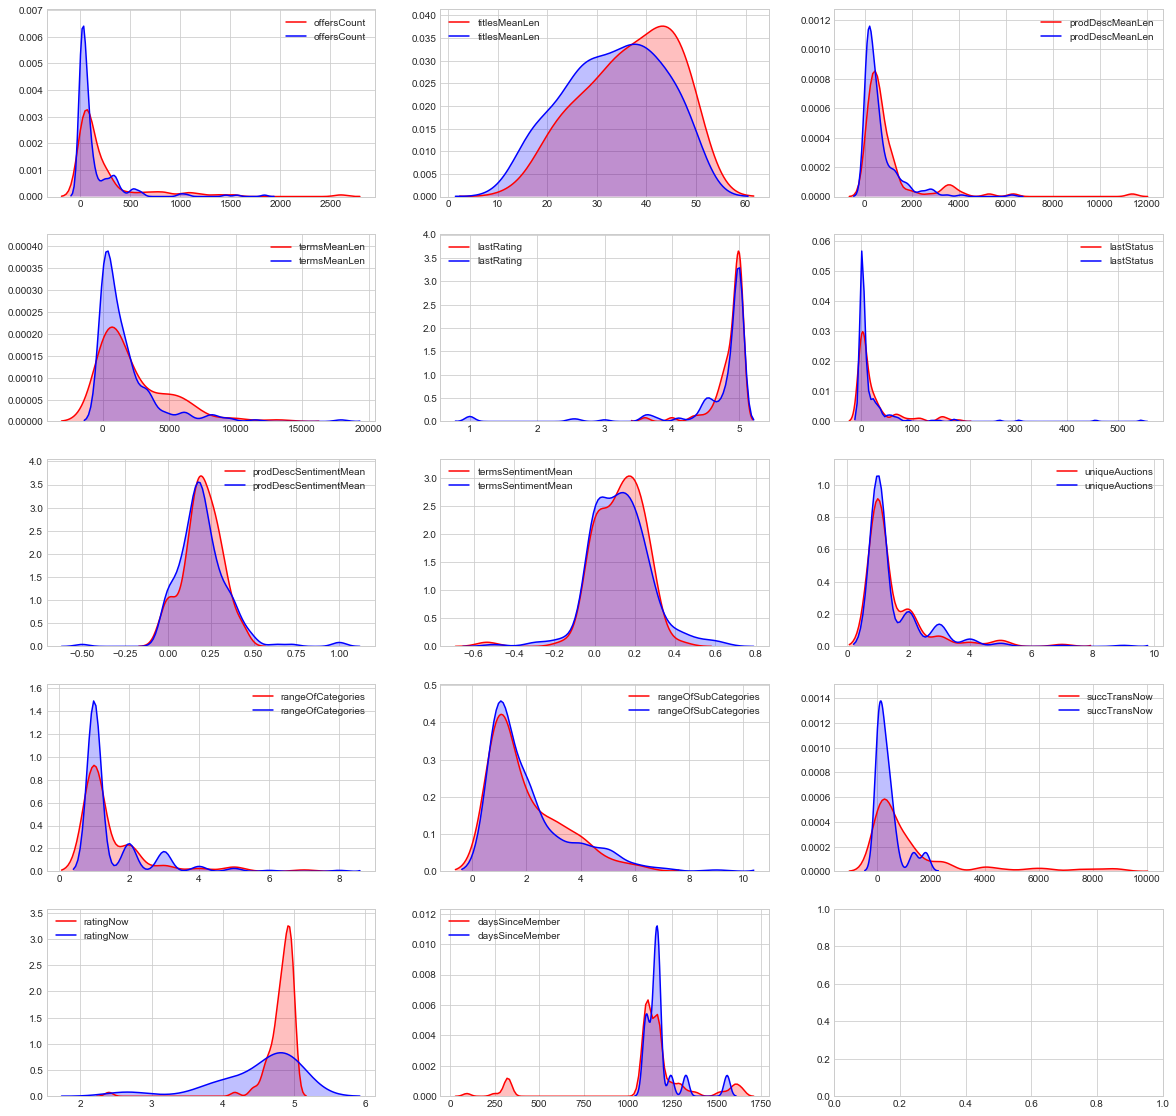

In [194]:
fig, ax = plt.subplots(5, 3, figsize=(20,20))
ax = ax.flatten()
for axe, n in zip(ax, numeric):
    a = sns.kdeplot(dmg[dmg['active2Years'] == 1][n], shade=True, color="r", ax = axe)
    b = sns.kdeplot(dmg[dmg['active2Years'] == 0][n], shade=True, color="b", ax = axe)
    m = max(a.get_lines()[0].get_data()[1].max(), b.get_lines()[1].get_data()[1].max())
    axe.set(ylim = (0, 1.1 * m))

After plotting, it seems that problem is hard to resolve - distributions are higly overlapped

In [195]:
# found out that in database there are vendors who registered after date of initial data (2015 / 2016). 
display(dmg[dmg['daysSinceMember'] < 400][['vendorName', 'memberSince', 'daysSinceMember']])
# it is possible that those vendors registered after prevoius vendors with the same nick deleted their accounts.
# Those obs must be excluded.
numeric.remove('daysSinceMember')
dmg = dmg.drop(dmg[dmg['daysSinceMember'] < 400].index.values, axis = 0)

,vendorName,memberSince,daysSinceMember
34,Cornerstore,01/10/2017,248
39,DeepMeds,24/07/2017,317
48,Drugsrus,19/07/2017,322
53,Dutchmen,28/07/2017,313
117,PerfectScans,24/07/2017,317
141,TheDrRx,09/07/2017,332
256,levistrauss,06/03/2018,92
259,littlemissy,08/07/2017,333
278,osquare,14/07/2017,327


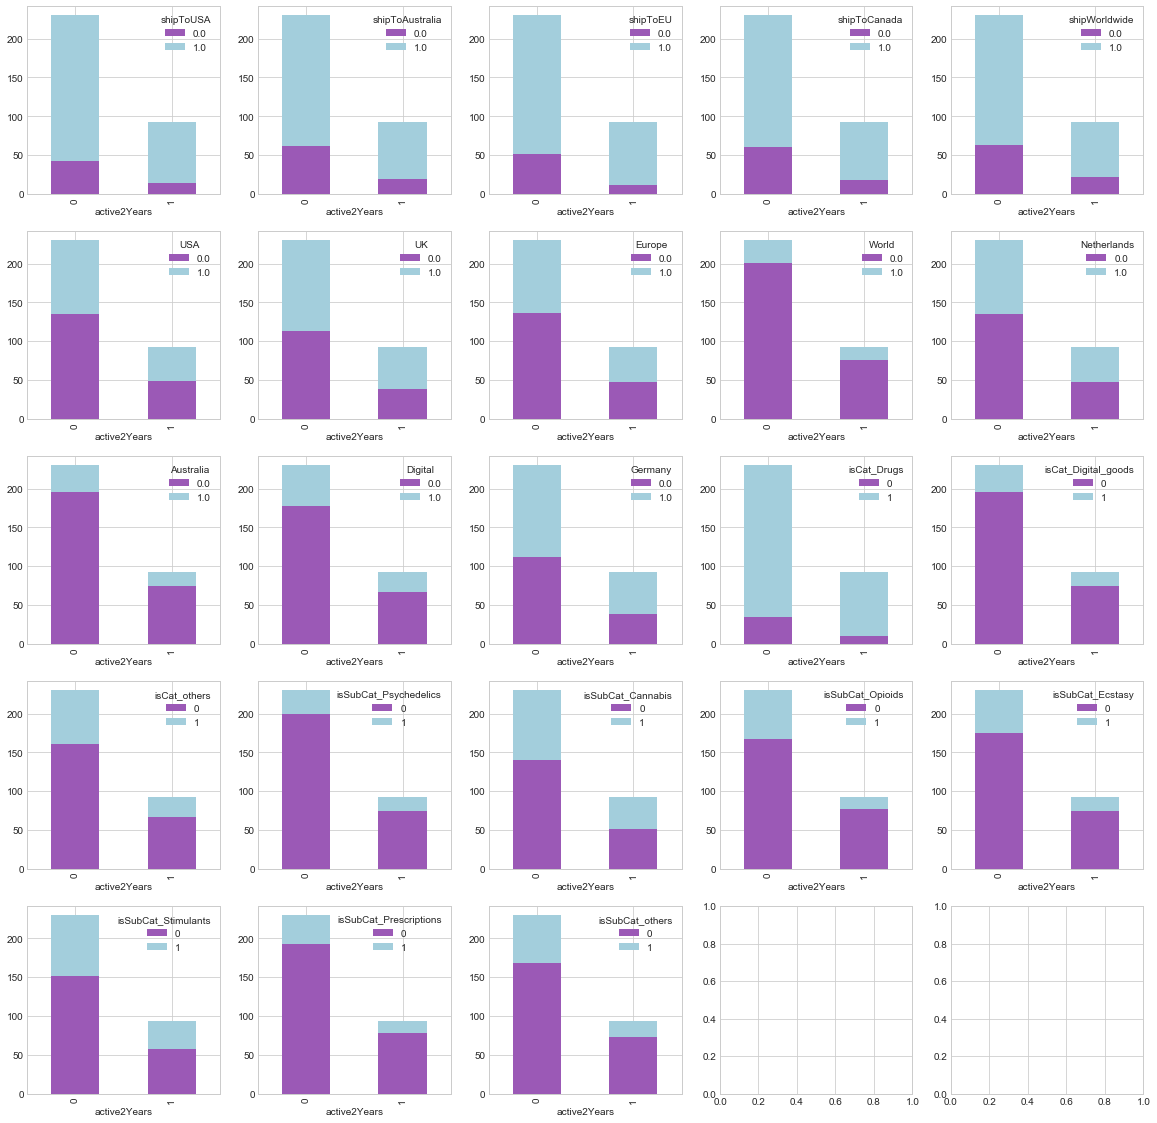

In [196]:
mod = ["#e74c3c", "#34495e"]
#sns.set_palette("mod")
fig, ax = plt.subplots(5, 5, figsize=(20,20))
ax = ax.flatten()
for axe, b in zip(ax, binary):
    df = pd.DataFrame({'active2Years': dmg['active2Years'].astype(int), b: dmg[b]})
    ct = pd.crosstab(df.active2Years, df[b])
    ct.plot.bar(ax = axe, stacked=True, color = ["#9b59b6", "#A3CEDC"])

    #plt.show()
    #sns.countplot(x = b, hue = 'active2Years', data = dmg, ax = axe, palette = 'muted')

In [197]:
# nulls
for col in dmg.columns.values:
    if dmg[col].isnull().sum() > 0:
        print(col, ':', dmg[col].isnull().sum(), 'nulls')

lastRating : 96 nulls
memberSince : 213 nulls
lastActive : 213 nulls
succTransNow : 218 nulls
ratingNow : 220 nulls
daysSinceLastActive : 213 nulls
daysSinceMember : 213 nulls


In [198]:
# remove variables with massive amount of nans, because they are prone to overfitting (big amount of nans are a part of 0's in class variable)
numeric.remove('succTransNow')
numeric.remove('ratingNow')

In [199]:
for col in dmg[numeric].columns.values:
    if dmg[col].isnull().sum() > 0:
        print(col, ':', dmg[col].isnull().sum(), 'nulls')

lastRating : 96 nulls


In [200]:
# what about lastRating? It has many nans, but maybe it is informable?
feature_selection.mutual_info_classif(dmg[~(dmg['lastRating'].isnull())]['lastRating'].values.reshape(-1, 1), dmg[~(dmg['lastRating'].isnull())]['active2Years'].values)

array([ 0.03713243])

In [201]:
# not really
numeric.remove('lastRating')

In [202]:
# export to make modeling in another notebook
dmg.to_csv('beforeFS.csv')